# Decision Trees and Random Forests
#### Ing. Luis Felipe Narvaez Gomez. E-mail: luis.narvaez@usantoto.edu.co. Cod: 2312660. Facultad de Ingenieria de Sistemas. USTA.

Reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

Reference_2: https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Decision-Tree-Levels

En este caso veremos un algoritmo que a diferencia de NaiveBayes, LinearRegression y SVM; este no es parametrico llamado RandomForest.

Los bosques aleatorios son un ejemplo de un conjunto.método, lo que significa que se basa en la agregación de los resultados de un conjunto de estimadores más simples. El resultado un tanto sorprendente con tales métodos de conjunto es que la suma puede ser mayor que las partes: es decir, ¡un voto mayoritario entre varios estimadores puede terminar siendo mejor que cualquiera de los estimadores individuales que votan! 

Veremos ejemplos de esto en las siguientes secciones. Comenzamos con las importaciones estándar:

Empecemos por importar algunas librerias base

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import Image

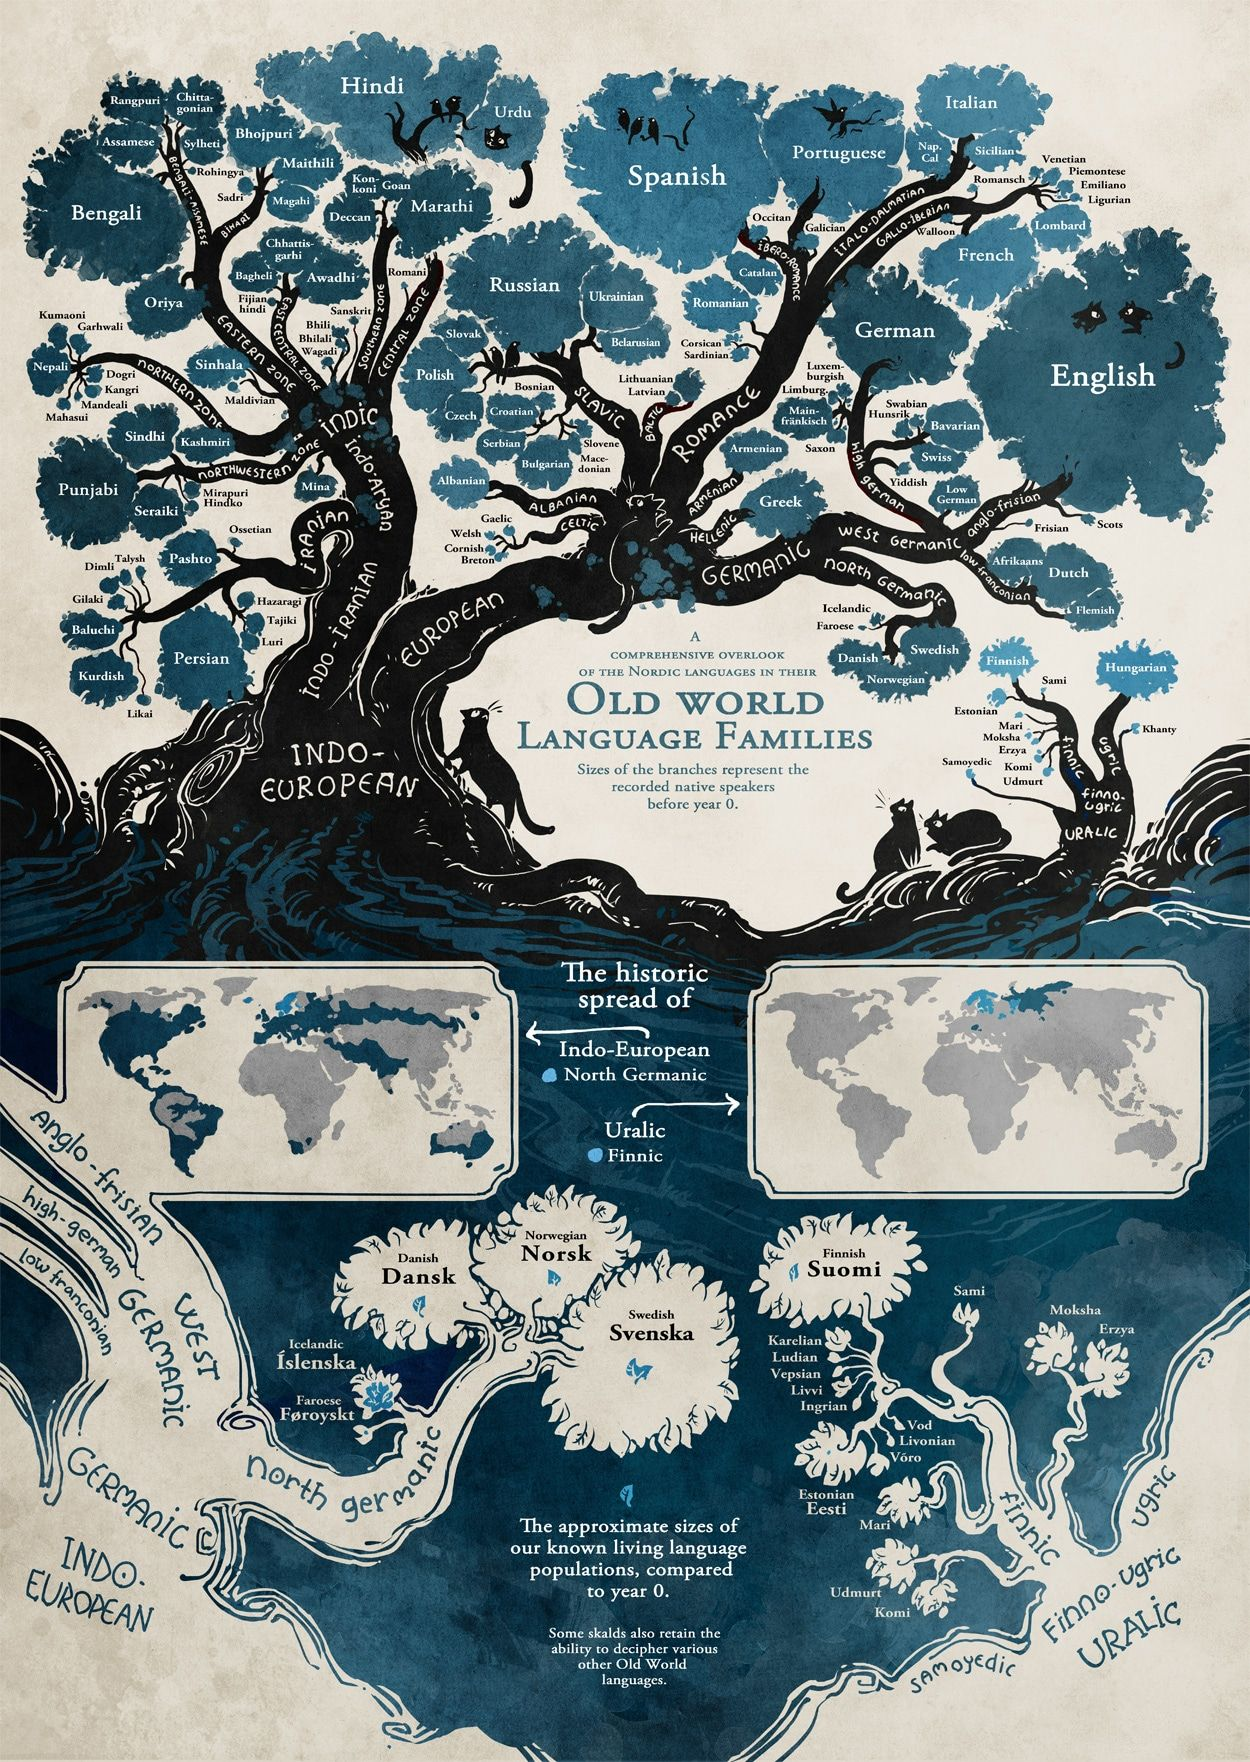

In [4]:
Image("Preciosa cartografía del árbol genealógico de la lingüística - Cultura Inquieta.jpg")

### Random Forest --> Decision Trees

Los bosques aleatorios son un ejemplo de un conjunto de aprendizaje basado en árboles de decisión. Por esta razón, comenzaremos discutiendo los propios árboles de decisión.

Los árboles de decisión son formas extremadamente intuitivas de clasificar o etiquetar objetos: simplemente haga una serie de preguntas diseñadas para concentrarse en la clasificación. 

Por ejemplo, si desea crear un árbol de decisiones para clasificar un animal con el que se encuentra durante una caminata, puede construir el siguiente esquema:


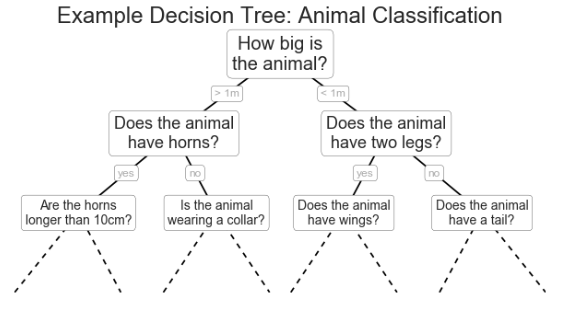

In [9]:
Image("DecisionTress.png")

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reducirá la cantidad de opciones a aproximadamente la mitad, reduciendo muy rápidamente las opciones incluso entre una gran cantidad de clases.

**El truco, por supuesto, está en decidir qué preguntas hacer en cada paso.*** 

En las implementaciones de ***aprendizaje automático*** de árboles de decisión, las preguntas generalmente toman la forma de ***divisiones alineadas con el eje en los datos*** es decir, cada nodo en el árbol divide los datos en dos grupos usando un valor de corte dentro de una de las características.

Considere los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase:

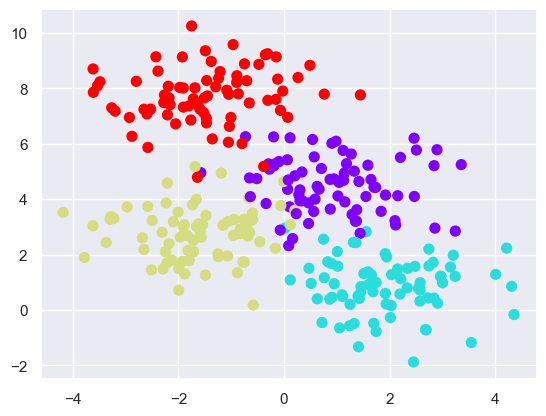

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un árbol de decisión simple construido sobre estos datos dividirá iterativamente los datos a lo largo de uno u otro eje de acuerdo con algún criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región de acuerdo con el voto mayoritario de los puntos dentro de ella. 

Esta figura presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos

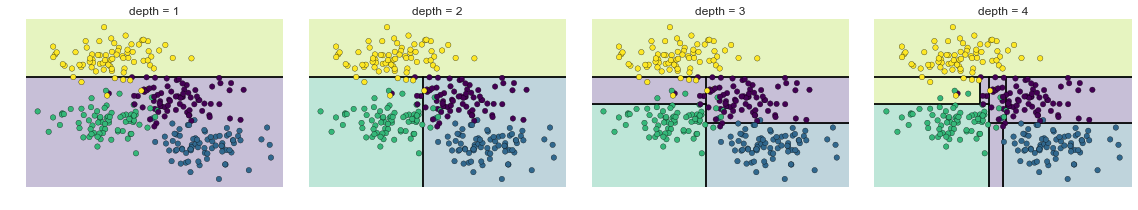

In [10]:
Image("DecisionTress_2.png")

Tenga en cuenta que después de la primera división, todos los puntos de la rama superior permanecen sin cambios, por lo que no es necesario subdividir más esta rama. A excepción de los nodos que contienen todo de un color, en cada nivel , cada región se divide nuevamente a lo largo de una de las dos características.

Este proceso de ajustar un árbol de decisión a nuestros datos se puede hacer en Scikit-Learn con el estimador "DecisionTreeClassifier":

In [11]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Escribamos una función de utilidad rápida para ayudarnos a visualizar la salida del clasificador:

In [12]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión:

C:\Users\Ruiso Local Pc\AppData\Local\Temp\ipykernel_11560\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


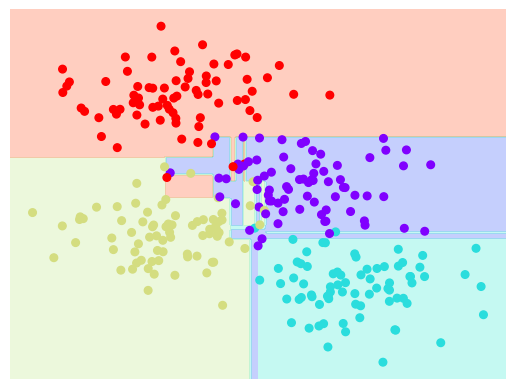

In [13]:
visualize_classifier(DecisionTreeClassifier(), X, y)

Ahora hagamos un parentesis para importar una definicion que podemos utilizar HELPERS_05_08

In [28]:
import helpers_05_08
# Aqui esta trayendo el archivo propio, local, helpers_05_08.py

In [27]:
helpers_05_08.plot_tree_interactive(X, y)

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

<function helpers_05_08.plot_tree_interactive.<locals>.interactive_tree(depth=5)>

In [29]:
helpers_05_08.plot_tree_interactive(X, y)

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

<function helpers_05_08.plot_tree_interactive.<locals>.interactive_tree(depth=5)>

Tenga en cuenta que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación de formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región morada alta y delgada entre las regiones amarilla y azul. Está claro que esto es menos el resultado de la verdadera distribución de datos intrínseca y más el resultado de las propiedades particulares de muestreo o ruido de los datos. Es decir, este árbol de decisiones, incluso con solo cinco niveles de profundidad, está claramente sobreajustado a nuestros datos.

### Decision trees - OverFitting

Tal ajuste excesivo resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar los detalles de los datos particulares en lugar de las propiedades generales de las distribuciones de las que se extraen. 

Otra forma de ver este sobreajuste es mirar modelos entrenados en diferentes subconjuntos de datos; por ejemplo, en esta figura entrenamos dos árboles diferentes, cada uno con la mitad de los datos originales:

In [32]:
from helpers_05_08 import visualize_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

C:\Users\Ruiso Local Pc\Desktop\BigData\Machine Learning Basics\helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
C:\Users\Ruiso Local Pc\Desktop\BigData\Machine Learning Basics\helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


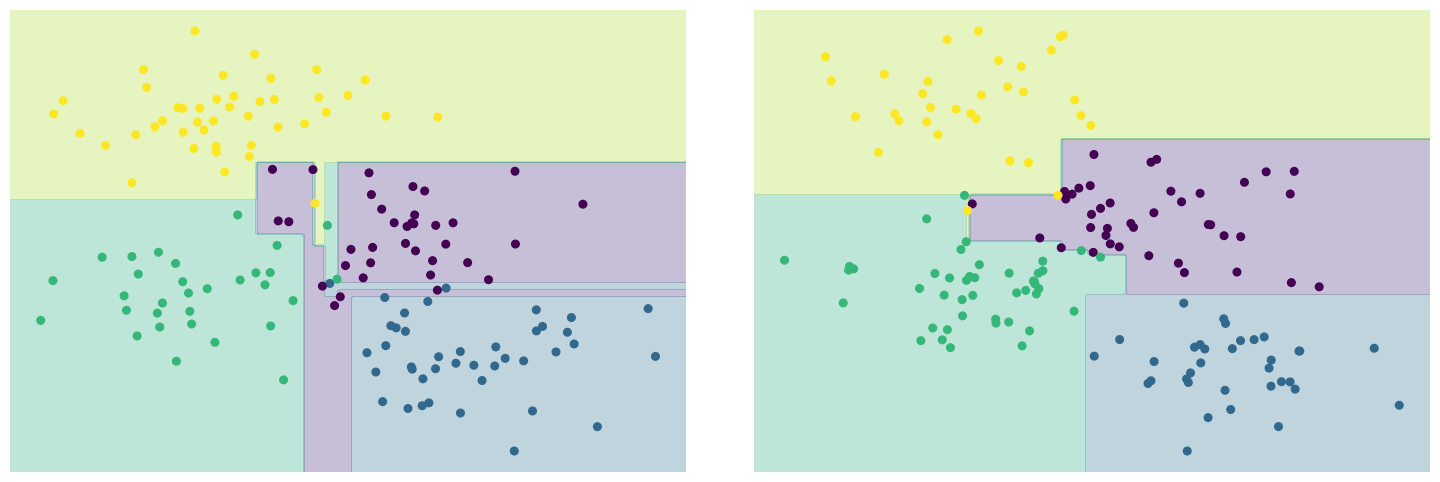

In [34]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

fig.savefig('05.08-decision-tree-overfitting.png')

Está claro que en algunos lugares, los dos árboles producen resultados consistentes (p. ej., en las cuatro esquinas), mientras que en otros lugares, los dos árboles dan clasificaciones muy diferentes (p. ej., en las regiones entre dos conglomerados)

La observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos segura y, por lo tanto, al usar información de estos dos árboles, ¡podríamos obtener un mejor resultado!

In [35]:
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

In [36]:
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

Así como el uso de información de dos árboles mejora nuestros resultados, podríamos esperar que el uso de información de muchos árboles mejoraría aún más nuestros resultados.

### Random Forest - Ensembles of Estimators

Esta noción, que se pueden combinar múltiples estimadores de sobreajuste para reducir el efecto de este sobreajuste, es lo que subyace en un método de conjunto llamado $BAGGING$.

El bagging o embolsado en español, utiliza un conjunto de estimadores paralelos, cada uno de los cuales sobreajusta los datos y promedia los resultados para encontrar una mejor clasificación. Un conjunto de árboles de decisión aleatorios se conoce como bosque aleatorio .

Este tipo de clasificación de $bagging$ se puede realizar manualmente utilizando el metaestimador de Scikit-Learn $BaggingClassifier$, como se muestra aquí:

C:\Users\Ruiso Local Pc\AppData\Local\Temp\ipykernel_11560\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


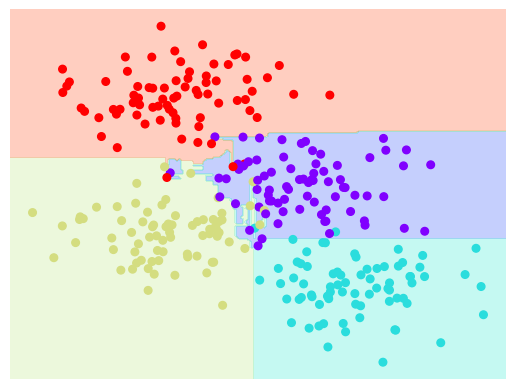

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80 % de los puntos de entrenamiento.

En la práctica, los árboles de decisión se aleatorizan de manera más efectiva al inyectar algo de estocasticidad en la forma en que se eligen las divisiones: de esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste aún tienen la aleatoriedad deseada.

Por ejemplo, al determinar en qué función dividir, el árbol aleatorio puede seleccionar entre las principales funciones.

En Scikit-Learn, este conjunto optimizado de árboles de decisión aleatorios se implementa en el **"RandomForestClassifierestimador"**, que se encarga de toda la aleatorización automáticamente. Todo lo que necesita hacer es seleccionar una cantidad de estimadores, y muy rápidamente (en paralelo, si lo desea) se ajustará al conjunto de árboles:

C:\Users\Ruiso Local Pc\AppData\Local\Temp\ipykernel_11560\520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


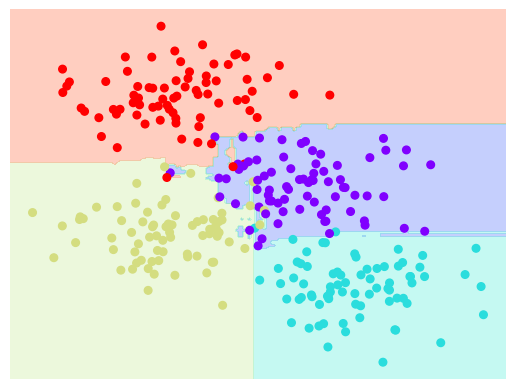

In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y)

Vemos que al promediar más de 100 modelos perturbados aleatoriamente, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo se debe dividir el espacio de parámetros.

### Random Forest Regression

En la sección anterior, consideramos los bosques aleatorios dentro del contexto de la clasificación.

También se puede hacer que los bosques aleatorios funcionen en el caso de regresión (es decir, variables continuas en lugar de categóricas).

El estimador a usar para esto es el **RandomForestRegressor**, y la sintaxis es muy similar a la que vimos antes.

Considere los siguientes datos, extraídos de la combinación de una oscilación rápida y lenta:

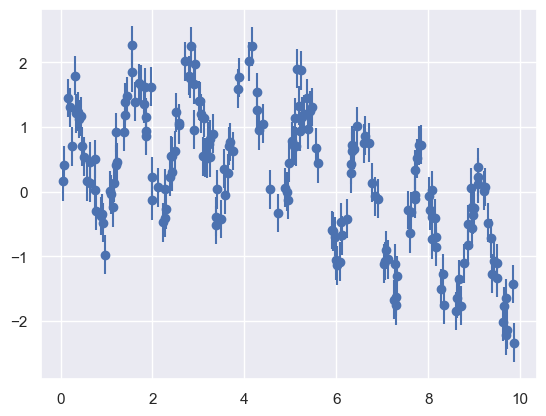

In [39]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o')

Usando el regresor de **RandomForestRegressor** , podemos encontrar la curva de mejor ajuste de la siguiente manera:

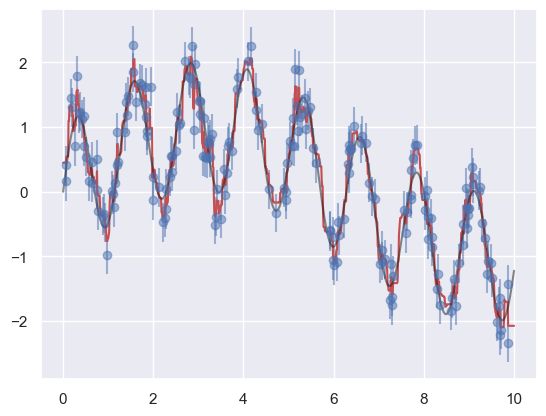

In [40]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5)

Aquí, el modelo real se muestra en la curva gris uniforme, mientras que el modelo de bosque aleatorio se muestra en la curva roja irregular. Como puede ver, el modelo de bosque aleatorio no paramétrico es lo suficientemente flexible como para adaptarse a los datos de varios períodos, ¡sin que tengamos que especificar un modelo de varios períodos!

### Ventajas

1. Tanto el entrenamiento como la predicción son muy rápidos debido a la simplicidad de los árboles de decisión subyacentes. Además, ambas tareas se pueden paralelizar directamente, porque los árboles individuales son entidades totalmente independientes.
2. Los árboles múltiples permiten una clasificación probabilística: un voto mayoritario entre los estimadores da una estimación de la probabilidad (se accede en Scikit-Learn con el metodo **predict_proba()**.
3. El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede funcionar bien en tareas que otros estimadores no se ajustan bien

### Desventajas

Una desventaja principal de los bosques aleatorios es que los resultados no son fáciles de interpretar: es decir, si desea sacar conclusiones sobre el significado del modelo de clasificación, es posible que los bosques aleatorios no sean la mejor opción.